In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras import layers
from keras import backend as K
from keras.engine.topology import Layer,InputSpec
from keras import initializers,regularizers,constraints
from keras.initializers import Initializer
from keras import regularizers


import tensorflow as tf
from keras.layers import Lambda


class MaxPlusDense(Layer):
    """A MaxPlus layer. TESTING MODE
    A `MaxPlus` layer takes the (element-wise + Bias) maximum of
      # Arguments
        output_dim: int > 0.
        init: name of initialization function for the weights of the layer
            (see [initializations](../initializations.md)),
            or alternatively, Theano function to use for weights
            initialization. This parameter is only relevant
            if you don't pass a `weights` argument.
        weights: list of Numpy arrays to set as initial weights.
            The list should have 2 elements, of shape `(input_dim, output_dim)`
            and (output_dim,) for weights and biases respectively.
        b_regularizer: instance of [WeightRegularizer](../regularizers.md),
            applied to the bias.
        activity_regularizer: instance of [ActivityRegularizer](../regularizers.md),
            applied to the network output.
        b_constraint: instance of the [constraints](../constraints.md) module,
            applied to the bias.
        bias: whether to include a bias
            (i.e. make the layer affine rather than linear).
        input_dim: dimensionality of the input (integer). This argument
            (or alternatively, the keyword argument `input_shape`)
            is required when using this layer as the first layer in a model.
    # Input shape
        2D tensor with shape: `(nb_samples, input_dim)`.
    # Output shape
        2D tensor with shape: `(nb_samples, output_dim)`.
    """

    def __init__(self, output_dim,
                 init='ones',
                 weights=None,
                 b_regularizer=None,
                 activity_regularizer=None,
                 b_constraint=None,
                 bias=True,
                 input_dim=None,
                 **kwargs):
        self.output_dim = output_dim
        self.init = initializers.get(init)

        self.b_regularizer = regularizers.get(b_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)
        self.input_dim = input_dim
        self.nb_feature = input_dim
        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(MaxPlusDense, self).__init__(**kwargs)

    def build(self, input_shape):
        input_dim = input_shape[1]
        self.nb_feature = input_dim 
        self.input_spec = InputSpec(dtype=K.floatx(),shape=(None, input_dim))
        if self.bias:
            self.b = self.add_weight((input_dim, self.output_dim,),
                                     initializer='zero',
                                     name='b',
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return (input_shape[0], self.output_dim)

    def call(self, x):
        output=K.concatenate([K.reshape(x, [-1, self.nb_feature, 1])]*self.output_dim)
        output -=self.b
        output = K.max(output, axis=1)
        return output
        
    def get_config(self):
        config = {'output_dim': self.output_dim,
                  'init': initializers.serialize(self.init),
                  'nb_feature': self.nb_feature,
                  'b_regularizer': regularizers.serialize(self.b_regularizer),
                  'activity_regularizer': regularizers.serialize(self.activity_regularizer),
                  'b_constraint': constraints.serialize(self.b_constraint),
                  'bias': self.bias,
                  'input_dim': self.input_dim}
        base_config = super(MaxPlusDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Using TensorFlow backend.


In [2]:
class Constraint(object):

    def __call__(self, w):
        return w

    def get_config(self):
        return {}

class non_neg_ones(Constraint):
    """Constrains the weights to be non-negative.
    """

    def __call__(self, w):
        w = K.cast(K.clip(w, 0.,1), K.floatx())
        return w
    
class non_neg(Constraint):
    
    def __call__(self, w):
        w = K.cast(K.clip(w, 0., 100000), K.floatx())
        return w

In [3]:
#NOTE: USE Dropout after MaxPlusDense

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 24

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [4]:
img_rows, img_cols = 28, 28
#dirf=dir('*.bmp');

x_train=(x_train.astype('float32'))/255
x_test=(x_test.astype('float32'))/255
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')
x_train=x_train[:240,:,:]
x_test=x_test[:240,:,:]
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

(60000, 28, 28) train samples
(10000, 28, 28) test samples
(240, 28, 28) train samples
(240, 28, 28) test samples


(240, 28, 28, 1)


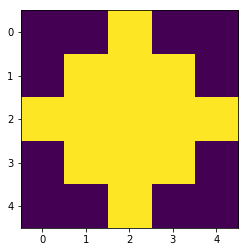

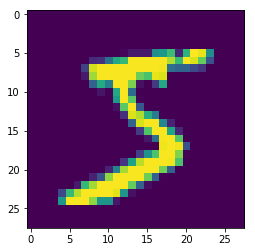

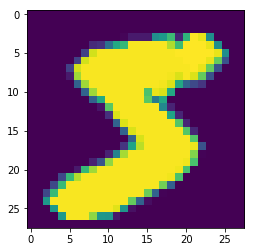

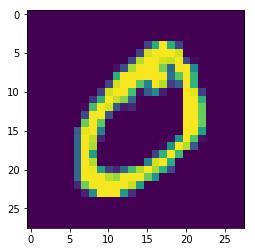

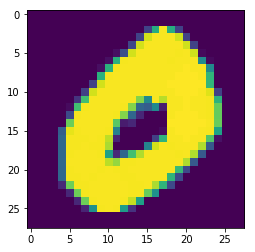

In [5]:
import skimage.morphology as skm
dil_x_train=np.zeros(x_train.shape)
print(x_train.shape)
#SE=skm.rectangle(10,1)
#SE=np.random.rand(21,21)
#SE=SE>(SE.max()-.01)
#SE=(SE>(SE.max()-.01))*np.power((SE-.1),3)
SE=skm.disk(2)
#SE2=skm.disk(2)
for i in range(x_train.shape[0]):
    dil_x_train[i,:,:,0]=skm.dilation(x_train[i,:,:][:,:,0],SE)
plt.imshow(SE,clim=[0,1])
plt.show()
plt.imshow(x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(x_train[1,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_train[1,:,:,0],clim=[0,1])
plt.show()
#print(SE)

In [6]:
SE.shape

(5, 5)

In [7]:
from keras.models import Model
from keras.layers import Input
from  keras.layers import Reshape
from keras.layers import Concatenate
from keras.layers import Maximum
from keras.constraints import non_neg

input_shape_decoder = (img_rows, img_cols,1)
input1 = Input(shape=input_shape)
x1=Flatten()(input1)
x2 = MaxPlusDense(img_rows*img_cols,b_constraint=non_neg_ones(),name='MaxPlus7')(x1)
xx=Reshape([28,28,1])(x2)
decoder_model=Model(input1,xx)
decoder_model.summary()

print(x_train.shape)
print(dil_x_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
MaxPlus7 (MaxPlusDense)      (None, 784)               614656    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 614,656
Trainable params: 614,656
Non-trainable params: 0
_________________________________________________________________
(240, 28, 28, 1)
(240, 28, 28, 1)


In [8]:
epochs = 100

decoder_model.compile(loss=keras.losses.mse,#binary_crossentropy
              optimizer=keras.optimizers.Adam(lr=.1),metrics=['mae'])
decoder_model.fit(x_train, dil_x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/100
240/240 [==============================] - 7s 31ms/step - loss: 0.6343 - mean_absolute_error: 0.6710
Epoch 2/100
240/240 [==============================] - 6s 27ms/step - loss: 0.4226 - mean_absolute_error: 0.5415
Epoch 3/100
240/240 [==============================] - 6s 26ms/step - loss: 0.2447 - mean_absolute_error: 0.4073
Epoch 4/100
240/240 [==============================] - 6s 27ms/step - loss: 0.1526 - mean_absolute_error: 0.3178
Epoch 5/100
240/240 [==============================] - 6s 27ms/step - loss: 0.0787 - mean_absolute_error: 0.2184
Epoch 6/100
240/240 [==============================] - 7s 31ms/step - loss: 0.0386 - mean_absolute_error: 0.1406
Epoch 7/100
240/240 [==============================] - 7s 30ms/step - loss: 0.0185 - mean_absolute_error: 0.0816
Epoch 8/100
240/240 [==============================] - 7s 28ms/step - loss: 0.0099 - mean_absolute_error: 0.0423
Epoch 9/100
240/240 [==============================] - 7s 28ms/step - loss: 0.0062 - mean_absolu

In [9]:
for layer in decoder_model.layers:
    print(layer.name)
    if layer.name=='MaxPlus7':
        D11 = layer.get_weights()
        print(len(D11))
        print(D11[0].shape)
        print(D11[0].min(),D11[0].max())


    if layer.name=='MaxPlus8':
        D12 = layer.get_weights()
        print(len(D12))
        print(D12[0].shape)
        print(D12[0].min(),D12[0].max())
        

input_1
flatten_1
MaxPlus7
1
(784, 784)
0.0 1.0
reshape_1


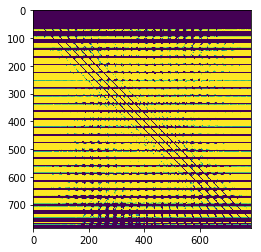

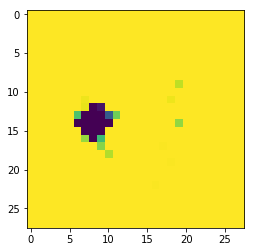

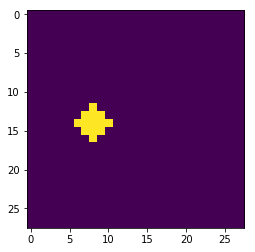

0.0
1.0


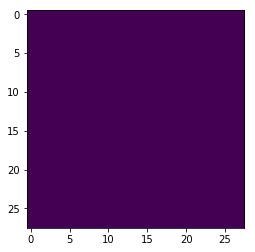

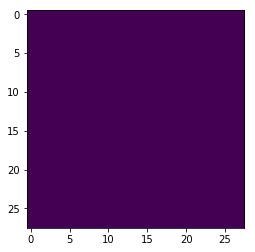

0.0
0.0


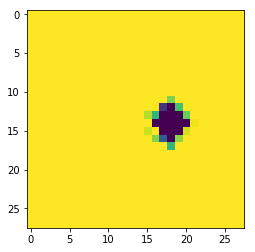

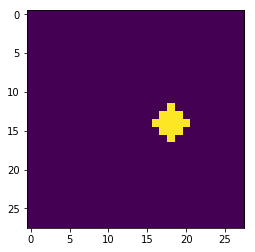

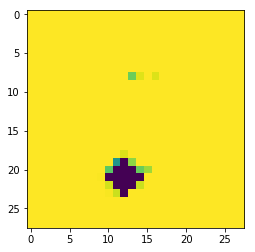

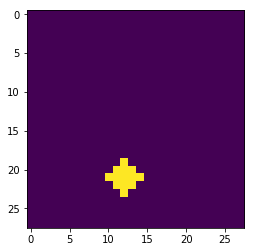

In [10]:

plt.imshow(D11[0])
plt.show()
plt.imshow(np.reshape(D11[0][400,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][400,:]==0,[28,28]))
plt.show()
print(D11[0][400,:].min())
print(D11[0][400,:].max())


plt.imshow(np.reshape(D11[0][1,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][1,:]==0,[28,28]))
plt.show()
print(D11[0][1,:].min())
print(D11[0][1,:].max())


plt.imshow(np.reshape(D11[0][410,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][410,:]==0,[28,28]))
plt.show()

plt.imshow(np.reshape(D11[0][600,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][600,:]==0,[28,28]))
plt.show()

#print(D11[0][400,:])
#plt.imshow(D12[0])
#plt.show()
#plt.imshow(np.reshape(D12[0][:,200],[28,28]))
#plt.show()

In [11]:
pred=decoder_model.predict(x_train[:,:,:,:])

In [12]:
print(pred.shape)
print(x_train.shape)


(240, 28, 28, 1)
(240, 28, 28, 1)


In [13]:
error=np.sum(np.sum(abs(pred-dil_x_train),axis=1),axis=1)
v=np.argsort(error,axis=0)

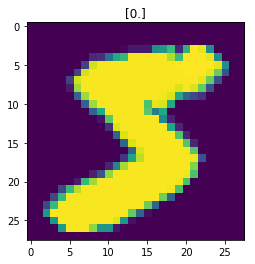

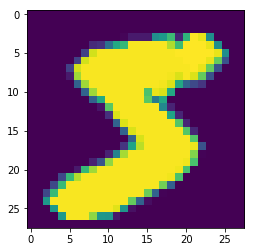

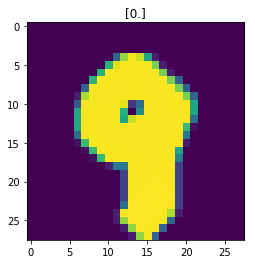

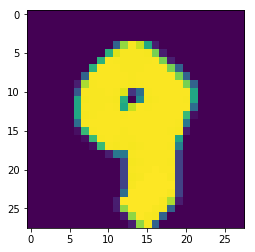

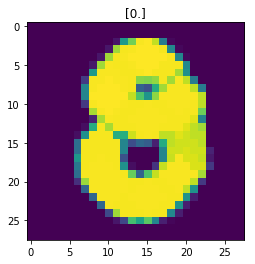

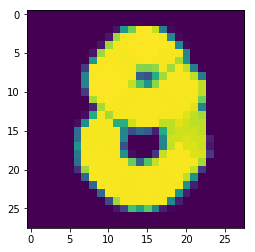

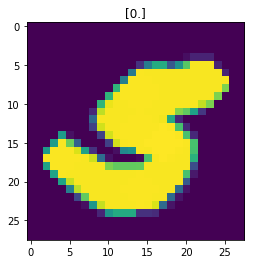

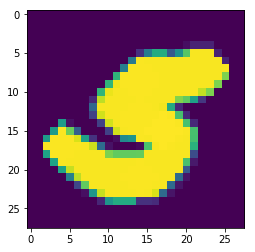

In [14]:
plt.imshow(pred[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_train[v[0][0],:,:,0])
plt.show()

plt.imshow(pred[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_train[v[11][0],:,:,0])
plt.show()

plt.imshow(pred[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_train[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_train[v[-1][0],:,:,0])
plt.show()

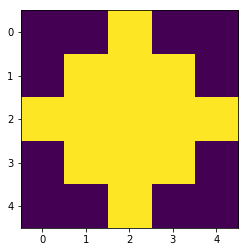

In [15]:
dil_x_test=np.zeros(x_test.shape)
SE=skm.disk(2)
for i in range(x_test.shape[0]):
    dil_x_test[i,:,:,0]=skm.dilation(x_test[i,:,:][:,:,0],SE)
plt.imshow(SE,clim=[0,1])

In [16]:
pred=decoder_model.predict(x_train[:,:,:,:])

In [17]:
pred_test=decoder_model.predict(x_test[:,:,:,:])

In [18]:
print(pred_test.shape)
print(x_test.shape)


(240, 28, 28, 1)
(240, 28, 28, 1)


In [19]:
error=np.sum(np.sum(abs(pred-dil_x_test),axis=1),axis=1)
v=np.argsort(error,axis=0)

In [20]:
error=np.sum(np.sum(abs(pred_test-dil_x_test),axis=1),axis=1)
v=np.argsort(error,axis=0)

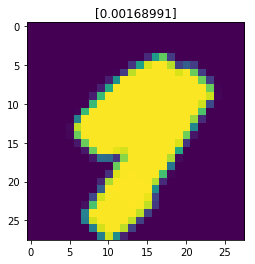

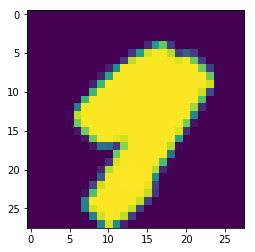

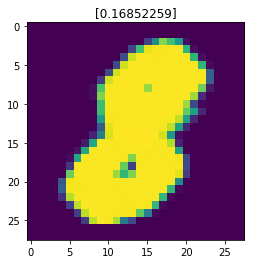

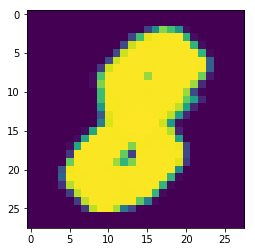

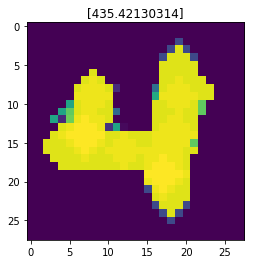

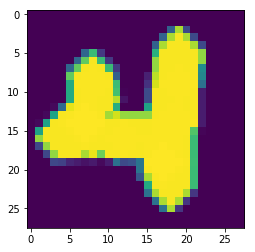

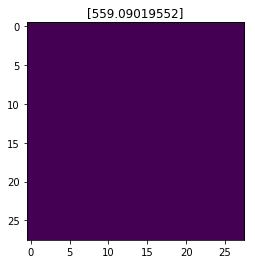

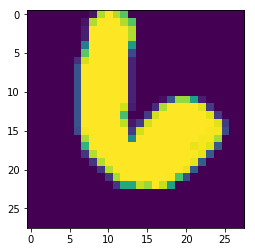

In [21]:
plt.imshow(pred_test[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_test[v[0][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_test[v[11][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_test[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_test[v[-1][0],:,:,0])
plt.show()

### Non-Neg constraint only

In [18]:
from keras.models import Model
from keras.layers import Input
from  keras.layers import Reshape
from keras.layers import Concatenate
from keras.layers import Maximum
from keras.constraints import non_neg

input_shape_decoder = (img_rows, img_cols,1)
input1 = Input(shape=input_shape)
x1=Flatten()(input1)
x2 = MaxPlusDense(img_rows*img_cols,b_constraint=non_neg(),name='MaxPlus7')(x1)
xx=Reshape([28,28,1])(x2)
decoder_model=Model(input1,xx)
decoder_model.summary()

print(x_train.shape)
print(dil_x_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
MaxPlus7 (MaxPlusDense)      (None, 784)               614656    
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
Total params: 614,656
Trainable params: 614,656
Non-trainable params: 0
_________________________________________________________________
(240, 28, 28, 1)
(240, 28, 28, 1)


In [19]:
epochs = 100

decoder_model.compile(loss=keras.losses.mse,#binary_crossentropy
              optimizer=keras.optimizers.Adam(lr=.1),metrics=['mae'])
decoder_model.fit(x_train, dil_x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/100
240/240 [==============================] - 6s 26ms/step - loss: 0.6153 - mean_absolute_error: 0.6604
Epoch 2/100
240/240 [==============================] - 6s 25ms/step - loss: 0.4124 - mean_absolute_error: 0.5347
Epoch 3/100
240/240 [==============================] - 6s 25ms/step - loss: 0.2406 - mean_absolute_error: 0.4027
Epoch 4/100
240/240 [==============================] - 6s 26ms/step - loss: 0.1413 - mean_absolute_error: 0.3038
Epoch 5/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0769 - mean_absolute_error: 0.2164
Epoch 6/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0375 - mean_absolute_error: 0.1390
Epoch 7/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0180 - mean_absolute_error: 0.0807
Epoch 8/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0095 - mean_absolute_error: 0.0409
Epoch 9/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0059 - mean_absolu

In [20]:
for layer in decoder_model.layers:
    print(layer.name)
    if layer.name=='MaxPlus7':
        D11 = layer.get_weights()
        print(len(D11))
        print(D11[0].shape)
        print(D11[0].min(),D11[0].max())


    if layer.name=='MaxPlus8':
        D12 = layer.get_weights()
        print(len(D12))
        print(D12[0].shape)
        print(D12[0].min(),D12[0].max())
        

input_2
flatten_2
MaxPlus7
1
(784, 784)
0.0 2.182769
reshape_2


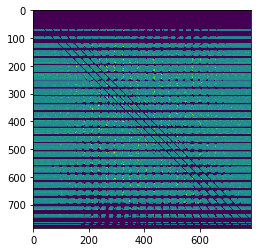

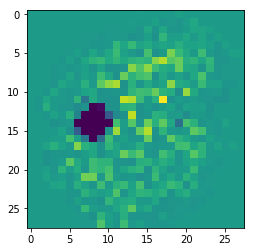

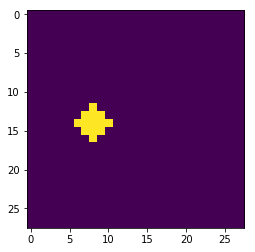

0.0
1.9696319


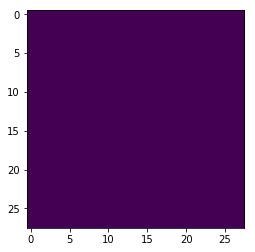

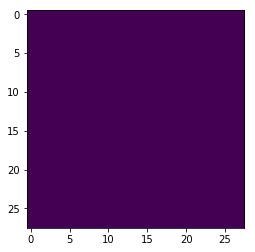

0.0
0.0


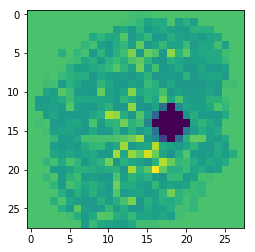

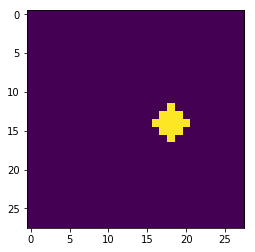

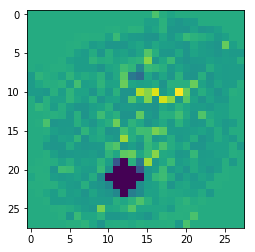

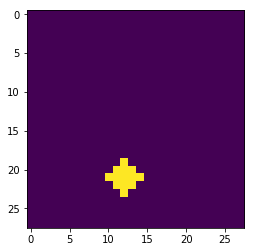

In [21]:

plt.imshow(D11[0])
plt.show()
plt.imshow(np.reshape(D11[0][400,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][400,:]==0,[28,28]))
plt.show()
print(D11[0][400,:].min())
print(D11[0][400,:].max())


plt.imshow(np.reshape(D11[0][1,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][1,:]==0,[28,28]))
plt.show()
print(D11[0][1,:].min())
print(D11[0][1,:].max())


plt.imshow(np.reshape(D11[0][410,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][410,:]==0,[28,28]))
plt.show()

plt.imshow(np.reshape(D11[0][600,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][600,:]==0,[28,28]))
plt.show()

#print(D11[0][400,:])
#plt.imshow(D12[0])
#plt.show()
#plt.imshow(np.reshape(D12[0][:,200],[28,28]))
#plt.show()

In [22]:
pred=decoder_model.predict(x_train[:,:,:,:])

In [23]:
print(pred.shape)
print(x_train.shape)


(240, 28, 28, 1)
(240, 28, 28, 1)


In [24]:
error=np.sum(np.sum(abs(pred-dil_x_train),axis=1),axis=1)
v=np.argsort(error,axis=0)

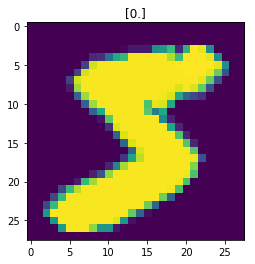

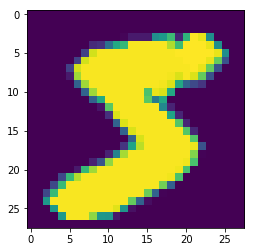

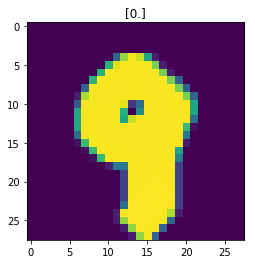

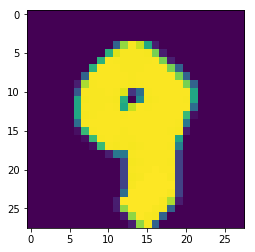

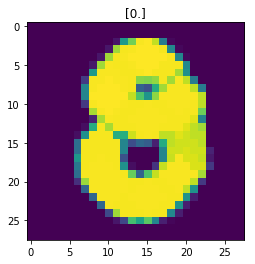

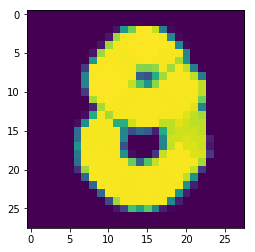

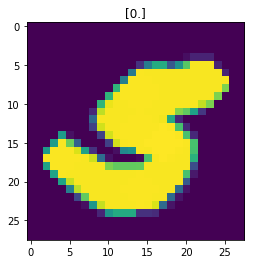

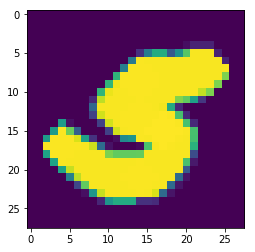

In [25]:
plt.imshow(pred[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_train[v[0][0],:,:,0])
plt.show()

plt.imshow(pred[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_train[v[11][0],:,:,0])
plt.show()

plt.imshow(pred[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_train[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_train[v[-1][0],:,:,0])
plt.show()

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../SourceCode')
from AsymAE_infoGAN_maxplus import max_plus_dense_layer
from custom_constraints import Between_0_and_1

In [10]:
from keras.models import Model
from keras.layers import Input
from  keras.layers import Reshape
from keras.layers import Concatenate
from keras.layers import Maximum
from keras.constraints import non_neg
import keras

input_shape_decoder = (img_rows, img_cols,1)
input1 = Input(shape=input_shape)
x1=Flatten()(input1)
x2 = max_plus_dense_layer.MaxPlusDense(img_rows*img_cols,use_bias=False, kernel_constraint=Between_0_and_1(),name='MaxPlus7')(x1)
xx=Reshape([28,28,1])(x2)
decoder_model=Model(input1,xx)
decoder_model.summary()

print(x_train.shape)
print(dil_x_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
MaxPlus7 (MaxPlusDense)      (None, 784)               614656    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 614,656
Trainable params: 614,656
Non-trainable params: 0
_________________________________________________________________
(240, 28, 28, 1)
(240, 28, 28, 1)


In [13]:
epochs = 100

decoder_model.compile(loss=keras.losses.mse,#binary_crossentropy
              optimizer=keras.optimizers.Adam(lr=.1),metrics=['mae'])
decoder_model.fit(x_train, dil_x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/100
240/240 [==============================] - 7s 30ms/step - loss: 0.6628 - mean_absolute_error: 0.6877
Epoch 2/100
240/240 [==============================] - 6s 25ms/step - loss: 0.5850 - mean_absolute_error: 0.6429
Epoch 3/100
240/240 [==============================] - 6s 25ms/step - loss: 0.3623 - mean_absolute_error: 0.4982
Epoch 4/100
240/240 [==============================] - 6s 25ms/step - loss: 0.2256 - mean_absolute_error: 0.3893
Epoch 5/100
240/240 [==============================] - 6s 25ms/step - loss: 0.1625 - mean_absolute_error: 0.3277
Epoch 6/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0889 - mean_absolute_error: 0.2318
Epoch 7/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0461 - mean_absolute_error: 0.1559
Epoch 8/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0234 - mean_absolute_error: 0.0967
Epoch 9/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0127 - mean_absolu

In [14]:
for layer in decoder_model.layers:
    print(layer.name)
    if layer.name=='MaxPlus7':
        D11 = layer.get_weights()
        print(len(D11))
        print(D11[0].shape)
        print(D11[0].min(),D11[0].max())


    if layer.name=='MaxPlus8':
        D12 = layer.get_weights()
        print(len(D12))
        print(D12[0].shape)
        print(D12[0].min(),D12[0].max())
        

input_2
flatten_2
MaxPlus7
1
(784, 784)
0.0 1.0
reshape_1


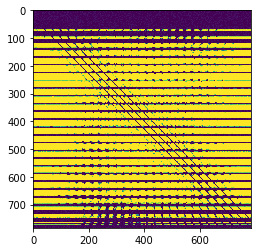

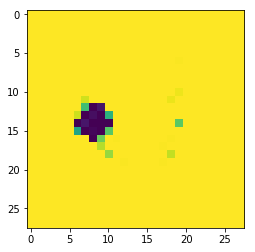

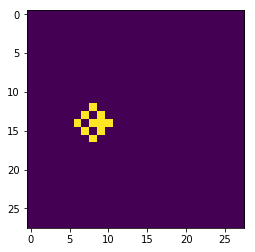

0.0
1.0


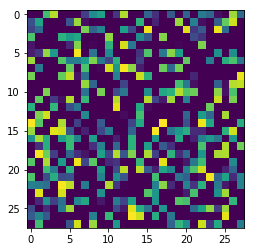

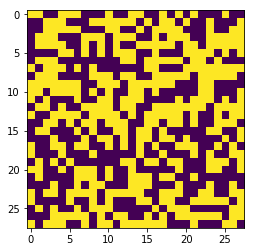

0.0
0.06105606


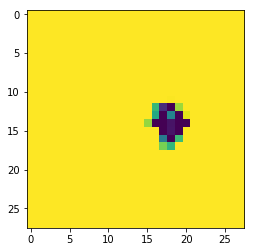

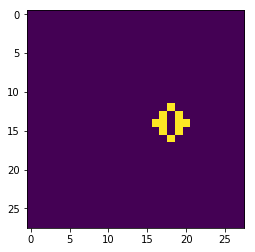

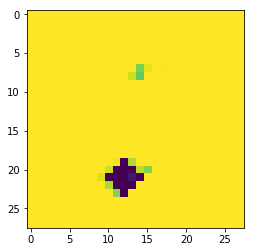

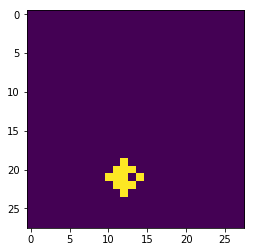

In [15]:

plt.imshow(D11[0])
plt.show()
plt.imshow(np.reshape(D11[0][400,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][400,:]==0,[28,28]))
plt.show()
print(D11[0][400,:].min())
print(D11[0][400,:].max())


plt.imshow(np.reshape(D11[0][1,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][1,:]==0,[28,28]))
plt.show()
print(D11[0][1,:].min())
print(D11[0][1,:].max())


plt.imshow(np.reshape(D11[0][410,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][410,:]==0,[28,28]))
plt.show()

plt.imshow(np.reshape(D11[0][600,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][600,:]==0,[28,28]))
plt.show()

#print(D11[0][400,:])
#plt.imshow(D12[0])
#plt.show()
#plt.imshow(np.reshape(D12[0][:,200],[28,28]))
#plt.show()

In [21]:
pred=decoder_model.predict(x_train[:,:,:,:])

In [22]:
print(pred.shape)
print(x_train.shape)


(240, 28, 28, 1)
(240, 28, 28, 1)


In [23]:
error=np.sum(np.sum(abs(pred-dil_x_train),axis=1),axis=1)
v=np.argsort(error,axis=0)

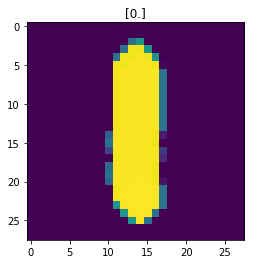

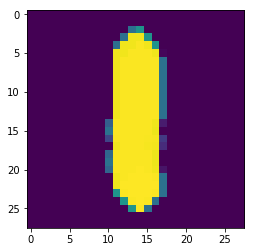

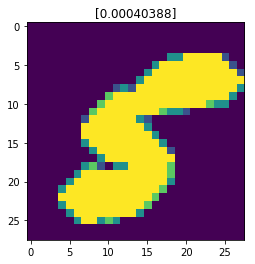

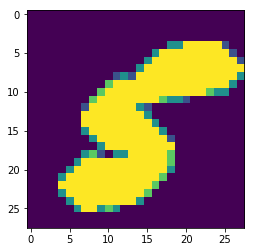

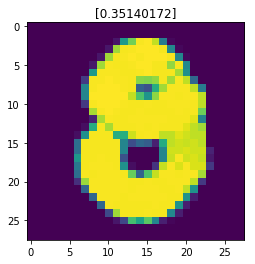

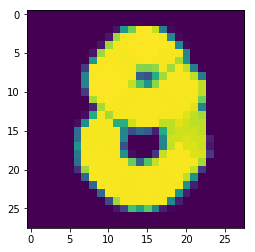

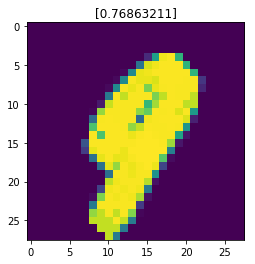

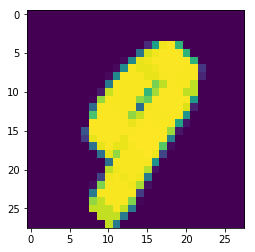

In [24]:
plt.imshow(pred[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_train[v[0][0],:,:,0])
plt.show()

plt.imshow(pred[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_train[v[11][0],:,:,0])
plt.show()

plt.imshow(pred[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_train[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_train[v[-1][0],:,:,0])
plt.show()

In [25]:
pred_test = decoder_model.predict(x_test)

In [26]:
SE=skm.disk(2)
#SE2=skm.disk(2)
dil_x_test = np.zeros(x_test.shape)
for i in range(x_test.shape[0]):
    dil_x_test[i,:,:,0]=skm.dilation(x_test[i,:,:][:,:,0],SE)


In [27]:
error=np.sum(np.sum(abs(pred_test-dil_x_test),axis=1),axis=1)
v=np.argsort(error,axis=0)

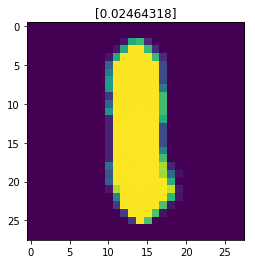

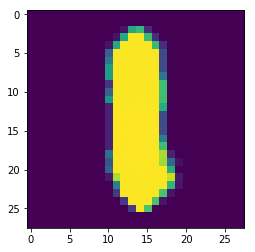

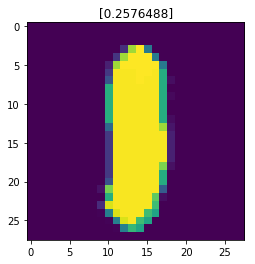

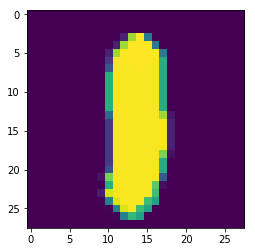

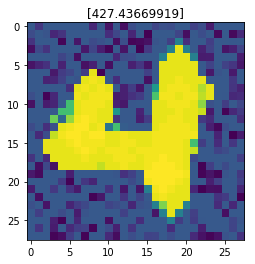

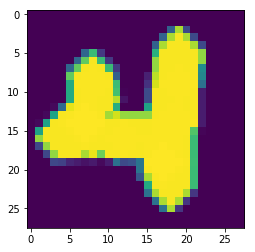

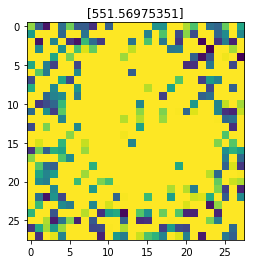

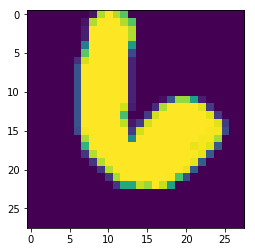

In [29]:
plt.imshow(pred_test[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_test[v[0][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_test[v[11][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_test[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_test[v[-1][0],:,:,0])
plt.show()

### 3. With initializing the weights to zero

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../SourceCode')
from AsymAE_infoGAN_maxplus import max_plus_dense_layer
from custom_constraints import Between_0_and_1

Using TensorFlow backend.


In [2]:
#NOTE: USE Dropout after MaxPlusDense

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 24

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


A local file was found, but it seems to be incomplete or outdated because the auto file hash does not match the original value of 8a61469f7ea1b51cbae51d4f78837e45 so we will re-download the data.
11493376/11490434 [==============================] - 3s 0us/step


In [3]:
img_rows, img_cols = 28, 28
#dirf=dir('*.bmp');

x_train=(x_train.astype('float32'))/255
x_test=(x_test.astype('float32'))/255
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')
x_train=x_train[:240,:,:]
x_test=x_test[:240,:,:]
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')


if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

(60000, 28, 28) train samples
(10000, 28, 28) test samples
(240, 28, 28) train samples
(240, 28, 28) test samples


(240, 28, 28, 1)


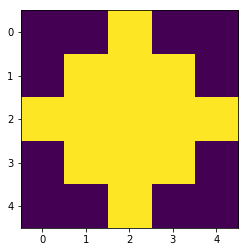

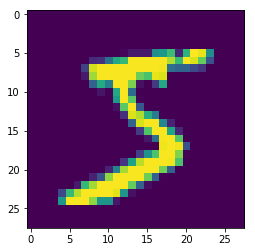

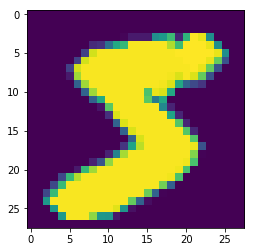

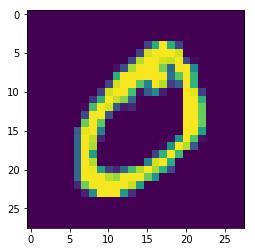

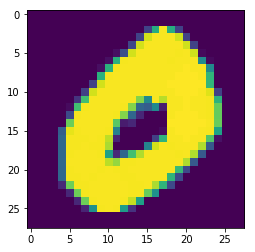

In [7]:
import skimage.morphology as skm
dil_x_train=np.zeros(x_train.shape)
print(x_train.shape)
#SE=skm.rectangle(10,1)
#SE=np.random.rand(21,21)
#SE=SE>(SE.max()-.01)
#SE=(SE>(SE.max()-.01))*np.power((SE-.1),3)
SE=skm.disk(2)
#SE2=skm.disk(2)
for i in range(x_train.shape[0]):
    dil_x_train[i,:,:,0]=skm.dilation(x_train[i,:,:][:,:,0],SE)
plt.imshow(SE,clim=[0,1])
plt.show()
plt.imshow(x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(x_train[1,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_train[1,:,:,0],clim=[0,1])
plt.show()
#print(SE)

In [8]:
from keras.models import Model
from keras.layers import Input
from  keras.layers import Reshape
from keras.layers import Concatenate
from keras.layers import Maximum
from keras.constraints import non_neg
import keras

input_shape_decoder = (img_rows, img_cols,1)
input1 = Input(shape=input_shape)
x1=Flatten()(input1)
x2 = max_plus_dense_layer.MaxPlusDense(img_rows*img_cols,use_bias=False, kernel_constraint=Between_0_and_1(),name='MaxPlus7', kernel_initializer='zeros')(x1)
xx=Reshape([28,28,1])(x2)
decoder_model=Model(input1,xx)
decoder_model.summary()

print(x_train.shape)
print(dil_x_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 784)               0         
_________________________________________________________________
MaxPlus7 (MaxPlusDense)      (None, 784)               614656    
_________________________________________________________________
reshape_3 (Reshape)          (None, 28, 28, 1)         0         
Total params: 614,656
Trainable params: 614,656
Non-trainable params: 0
_________________________________________________________________
(240, 28, 28, 1)
(240, 28, 28, 1)


In [9]:
epochs = 100

decoder_model.compile(loss=keras.losses.mse,#binary_crossentropy
              optimizer=keras.optimizers.Adam(lr=.1),metrics=['mae'])
decoder_model.fit(x_train, dil_x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/100
240/240 [==============================] - 7s 28ms/step - loss: 0.6181 - mean_absolute_error: 0.6619
Epoch 2/100
240/240 [==============================] - 7s 27ms/step - loss: 0.4022 - mean_absolute_error: 0.5281
Epoch 3/100
240/240 [==============================] - 6s 27ms/step - loss: 0.2442 - mean_absolute_error: 0.4064
Epoch 4/100
240/240 [==============================] - 7s 27ms/step - loss: 0.1456 - mean_absolute_error: 0.3090
Epoch 5/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0767 - mean_absolute_error: 0.2152
Epoch 6/100
240/240 [==============================] - 6s 26ms/step - loss: 0.0378 - mean_absolute_error: 0.1387
Epoch 7/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0184 - mean_absolute_error: 0.0806
Epoch 8/100
240/240 [==============================] - 6s 25ms/step - loss: 0.0099 - mean_absolute_error: 0.0411
Epoch 9/100
240/240 [==============================] - 7s 27ms/step - loss: 0.0063 - mean_absolu

In [10]:
for layer in decoder_model.layers:
    print(layer.name)
    if layer.name=='MaxPlus7':
        D11 = layer.get_weights()
        print(len(D11))
        print(D11[0].shape)
        print(D11[0].min(),D11[0].max())


    if layer.name=='MaxPlus8':
        D12 = layer.get_weights()
        print(len(D12))
        print(D12[0].shape)
        print(D12[0].min(),D12[0].max())
        

input_3
flatten_3
MaxPlus7
1
(784, 784)
0.0 1.0
reshape_3


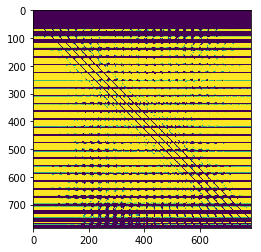

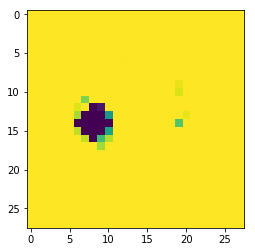

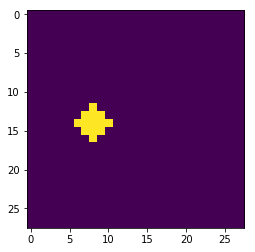

0.0
1.0


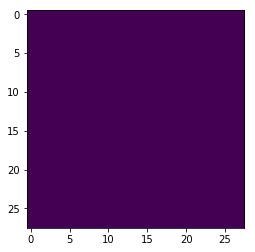

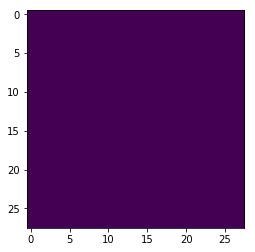

0.0
0.0


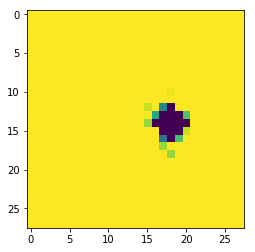

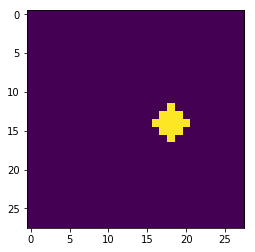

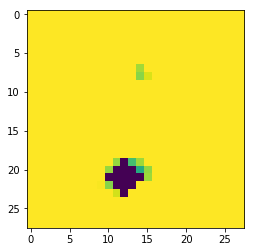

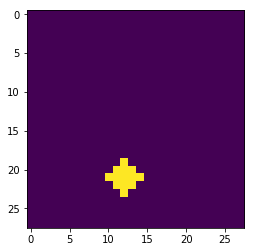

In [11]:

plt.imshow(D11[0])
plt.show()
plt.imshow(np.reshape(D11[0][400,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][400,:]==0,[28,28]))
plt.show()
print(D11[0][400,:].min())
print(D11[0][400,:].max())


plt.imshow(np.reshape(D11[0][1,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][1,:]==0,[28,28]))
plt.show()
print(D11[0][1,:].min())
print(D11[0][1,:].max())


plt.imshow(np.reshape(D11[0][410,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][410,:]==0,[28,28]))
plt.show()

plt.imshow(np.reshape(D11[0][600,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][600,:]==0,[28,28]))
plt.show()

#print(D11[0][400,:])
#plt.imshow(D12[0])
#plt.show()
#plt.imshow(np.reshape(D12[0][:,200],[28,28]))
#plt.show()

In [12]:
pred=decoder_model.predict(x_train[:,:,:,:])

In [13]:
print(pred.shape)
print(x_train.shape)


(240, 28, 28, 1)
(240, 28, 28, 1)


In [14]:
error=np.sum(np.sum(abs(pred-dil_x_train),axis=1),axis=1)
v=np.argsort(error,axis=0)

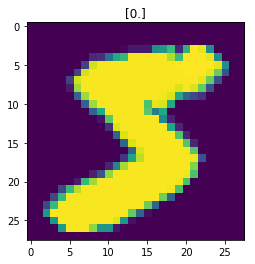

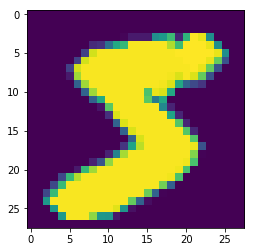

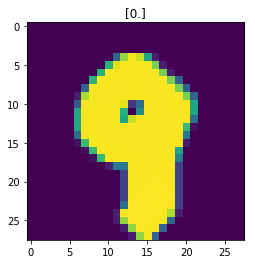

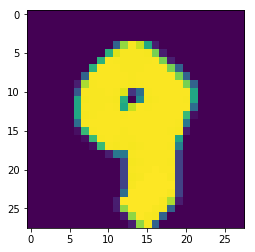

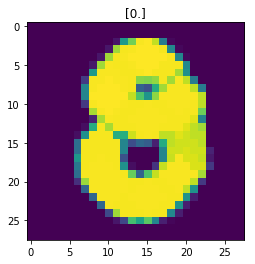

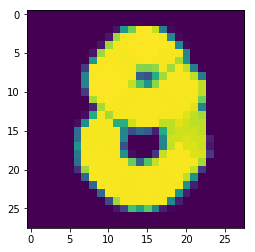

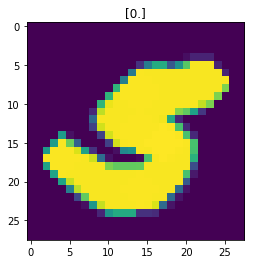

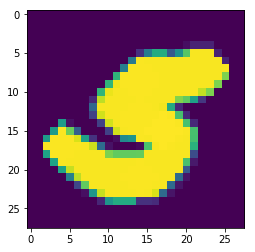

In [15]:
plt.imshow(pred[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_train[v[0][0],:,:,0])
plt.show()

plt.imshow(pred[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_train[v[11][0],:,:,0])
plt.show()

plt.imshow(pred[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_train[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_train[v[-1][0],:,:,0])
plt.show()

In [16]:
pred_test = decoder_model.predict(x_test)

In [17]:
SE=skm.disk(2)
#SE2=skm.disk(2)
dil_x_test = np.zeros(x_test.shape)
for i in range(x_test.shape[0]):
    dil_x_test[i,:,:,0]=skm.dilation(x_test[i,:,:][:,:,0],SE)


In [18]:
error=np.sum(np.sum(abs(pred_test-dil_x_test),axis=1),axis=1)
v=np.argsort(error,axis=0)

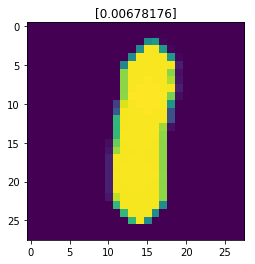

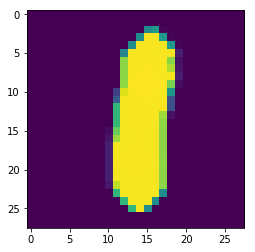

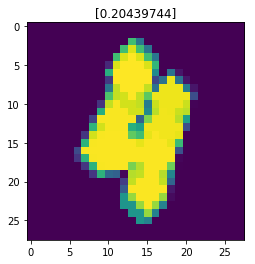

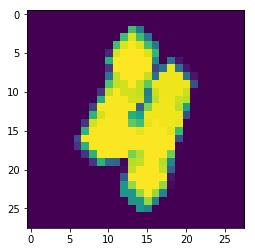

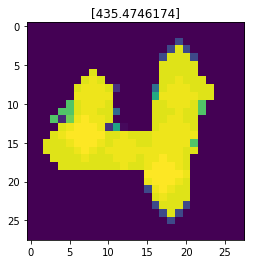

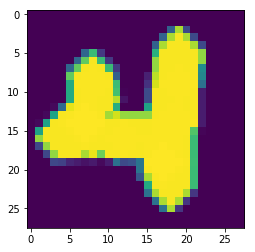

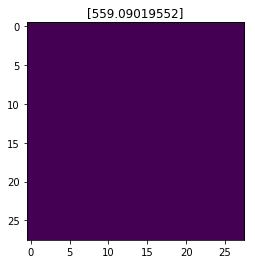

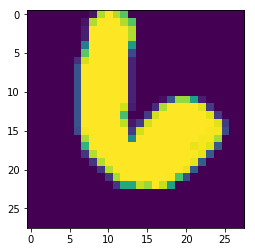

In [19]:
plt.imshow(pred_test[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_test[v[0][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_test[v[11][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_test[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_test[v[-1][0],:,:,0])
plt.show()

### Testing the MaxPlusDense Layer with a biger number of training points 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../SourceCode')
from AsymAE_infoGAN_maxplus import max_plus_dense_layer
from custom_constraints import Between_0_and_1

Using TensorFlow backend.


In [3]:
#NOTE: USE Dropout after MaxPlusDense

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [4]:
img_rows, img_cols = 28, 28
x_train=(x_train.astype('float32'))/255
x_test=(x_test.astype('float32'))/255
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

(60000, 28, 28) train samples
(10000, 28, 28) test samples


(60000, 28, 28, 1)


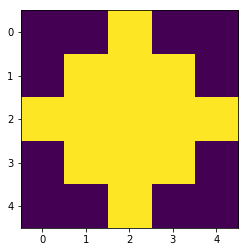

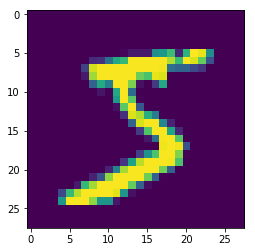

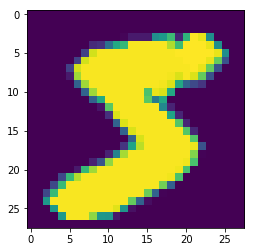

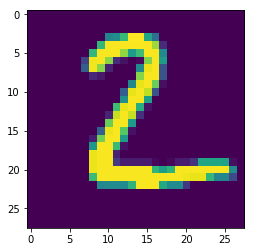

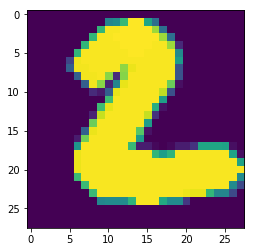

In [5]:
import skimage.morphology as skm
dil_x_train=np.zeros(x_train.shape)
print(x_train.shape)
SE=skm.disk(2)
for i in range(x_train.shape[0]):
    dil_x_train[i,:,:,0]=skm.dilation(x_train[i,:,:][:,:,0],SE)
dil_x_test = np.zeros(x_test.shape)
for i in range(x_test.shape[0]):
    dil_x_test[i,:,:,0]=skm.dilation(x_test[i,:,:][:,:,0],SE)
    
plt.imshow(SE,clim=[0,1])
plt.show()
plt.imshow(x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(x_test[1,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_test[1,:,:,0],clim=[0,1])
plt.show()

In [6]:
from keras.models import Model
from keras.layers import Input
from  keras.layers import Reshape
from keras.layers import Concatenate
from keras.layers import Maximum
from keras.constraints import non_neg
import keras

input_shape_decoder = (img_rows, img_cols,1)
input1 = Input(shape=input_shape)
x1=Flatten()(input1)
x2 = max_plus_dense_layer.MaxPlusDense(img_rows*img_cols,use_bias=False, kernel_constraint=Between_0_and_1(),name='MaxPlus7')(x1)
xx=Reshape([28,28,1])(x2)
decoder_model=Model(input1,xx)
decoder_model.summary()

print(x_train.shape)
print(dil_x_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
MaxPlus7 (MaxPlusDense)      (None, 784)               614656    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 614,656
Trainable params: 614,656
Non-trainable params: 0
_________________________________________________________________
(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [8]:
epochs = 100
batch_size = 64

decoder_model.compile(loss=keras.losses.mse,#binary_crossentropy
              optimizer=keras.optimizers.Adam(lr=.1),metrics=['mae'])
decoder_model.fit(x_train[:2000], dil_x_train[:2000],
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/100
2000/2000 [==============================] - 50s 25ms/step - loss: 0.3261 - mean_absolute_error: 0.4589
Epoch 2/100
2000/2000 [==============================] - 49s 25ms/step - loss: 0.0427 - mean_absolute_error: 0.1317
Epoch 3/100
2000/2000 [==============================] - 49s 25ms/step - loss: 0.0059 - mean_absolute_error: 0.0188
Epoch 4/100
2000/2000 [==============================] - 49s 25ms/step - loss: 0.0017 - mean_absolute_error: 0.0063
Epoch 5/100
2000/2000 [==============================] - 50s 25ms/step - loss: 5.6999e-04 - mean_absolute_error: 0.0025
Epoch 6/100
2000/2000 [==============================] - 50s 25ms/step - loss: 1.8687e-04 - mean_absolute_error: 9.9102e-04
Epoch 7/100
2000/2000 [==============================] - 50s 25ms/step - loss: 5.6177e-05 - mean_absolute_error: 3.8775e-04
Epoch 8/100
2000/2000 [==============================] - 49s 25ms/step - loss: 2.1615e-05 - mean_absolute_error: 1.7300e-04
Epoch 9/100
2000/2000 [=====================

In [9]:
for layer in decoder_model.layers:
    print(layer.name)
    if layer.name=='MaxPlus7':
        D11 = layer.get_weights()
        print(len(D11))
        print(D11[0].shape)
        print(D11[0].min(),D11[0].max())


    if layer.name=='MaxPlus8':
        D12 = layer.get_weights()
        print(len(D12))
        print(D12[0].shape)
        print(D12[0].min(),D12[0].max())
        

input_1
flatten_1
MaxPlus7
1
(784, 784)
0.0 1.0
reshape_1


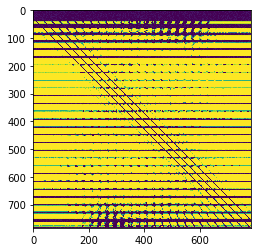

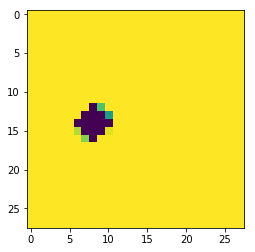

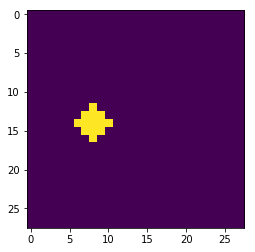

0.0
1.0


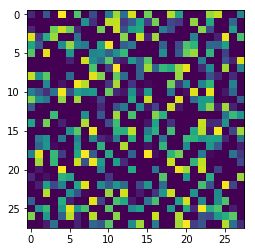

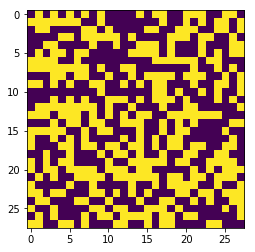

0.0
0.06162459


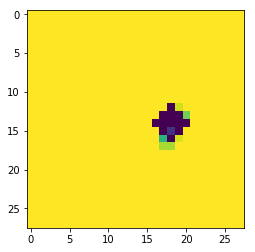

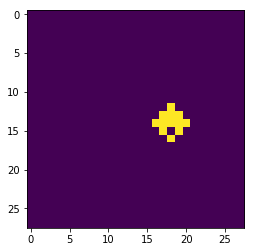

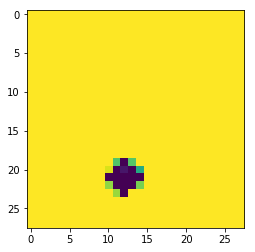

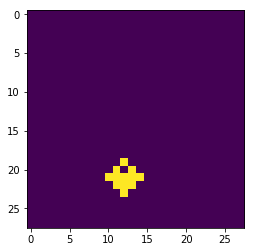

In [10]:

plt.imshow(D11[0])
plt.show()
plt.imshow(np.reshape(D11[0][400,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][400,:]==0,[28,28]))
plt.show()
print(D11[0][400,:].min())
print(D11[0][400,:].max())


plt.imshow(np.reshape(D11[0][1,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][1,:]==0,[28,28]))
plt.show()
print(D11[0][1,:].min())
print(D11[0][1,:].max())


plt.imshow(np.reshape(D11[0][410,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][410,:]==0,[28,28]))
plt.show()

plt.imshow(np.reshape(D11[0][600,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][600,:]==0,[28,28]))
plt.show()

#print(D11[0][400,:])
#plt.imshow(D12[0])
#plt.show()
#plt.imshow(np.reshape(D12[0][:,200],[28,28]))
#plt.show()

In [11]:
pred=decoder_model.predict(x_train[:,:,:,:])

In [12]:
print(pred.shape)
print(x_train.shape)


(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [13]:
error=np.sum(np.sum(abs(pred-dil_x_train),axis=1),axis=1)
v=np.argsort(error,axis=0)

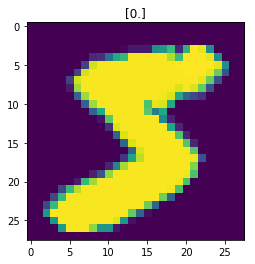

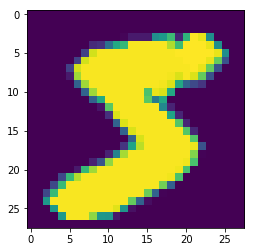

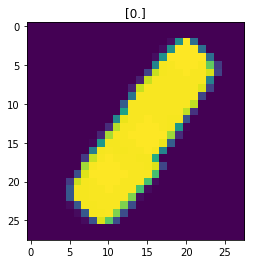

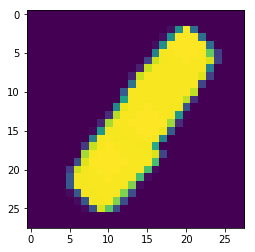

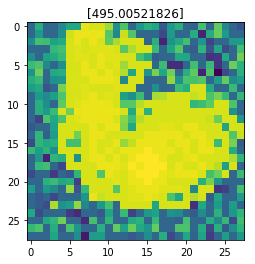

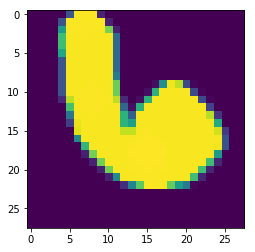

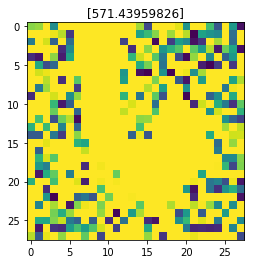

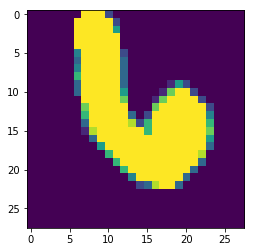

In [14]:
plt.imshow(pred[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_train[v[0][0],:,:,0])
plt.show()

plt.imshow(pred[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_train[v[11][0],:,:,0])
plt.show()

plt.imshow(pred[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_train[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_train[v[-1][0],:,:,0])
plt.show()

In [15]:
pred_test = decoder_model.predict(x_test)

In [16]:
error=np.sum(np.sum(abs(pred_test-dil_x_test),axis=1),axis=1)
v=np.argsort(error,axis=0)

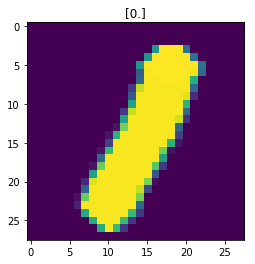

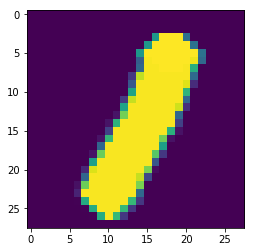

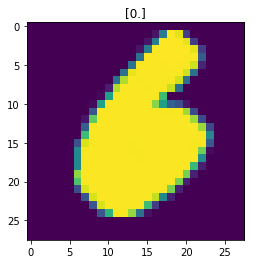

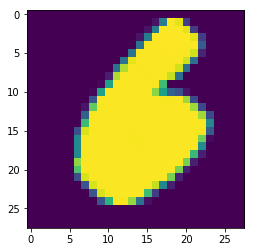

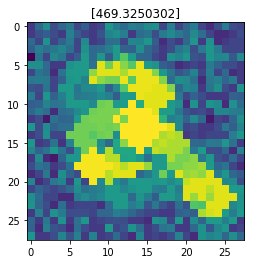

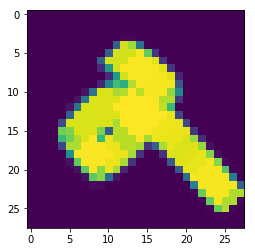

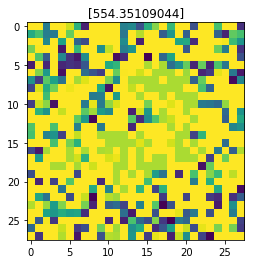

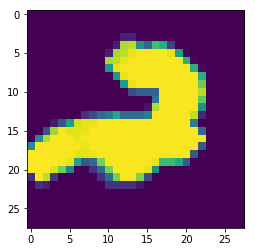

In [17]:
plt.imshow(pred_test[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_test[v[0][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_test[v[11][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_test[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_test[v[-1][0],:,:,0])
plt.show()

### Using all training points

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../SourceCode')
from AsymAE_infoGAN_maxplus import max_plus_dense_layer
from custom_constraints import Between_0_and_1

Using TensorFlow backend.


In [2]:
#NOTE: USE Dropout after MaxPlusDense

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [3]:
img_rows, img_cols = 28, 28
x_train=(x_train.astype('float32'))/255
x_test=(x_test.astype('float32'))/255
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

(60000, 28, 28) train samples
(10000, 28, 28) test samples


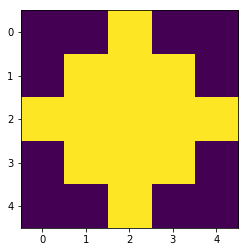

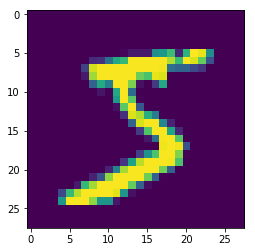

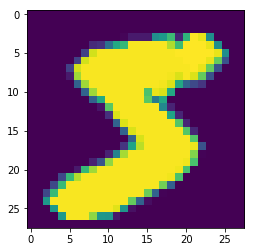

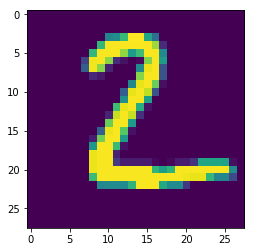

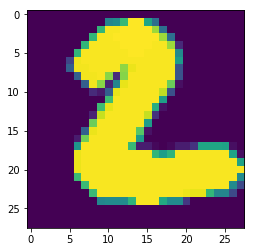

In [4]:
import skimage.morphology as skm
dil_x_train=np.zeros(x_train.shape)
SE=skm.disk(2)
for i in range(x_train.shape[0]):
    dil_x_train[i,:,:,0]=skm.dilation(x_train[i,:,:,0],SE)
dil_x_test = np.zeros(x_test.shape)
for i in range(x_test.shape[0]):
    dil_x_test[i,:,:,0]=skm.dilation(x_test[i,:,:,0],SE)
    
plt.imshow(SE,clim=[0,1])
plt.show()
plt.imshow(x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(x_test[1,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_test[1,:,:,0],clim=[0,1])
plt.show()

In [5]:
from keras.models import Model
from keras.layers import Input
from  keras.layers import Reshape
from keras.layers import Concatenate
from keras.layers import Maximum
from keras.constraints import non_neg
import keras

input_shape_decoder = (img_rows, img_cols,1)
input1 = Input(shape=input_shape)
x1=Flatten()(input1)
x2 = max_plus_dense_layer.MaxPlusDense(img_rows*img_cols,use_bias=False, kernel_constraint=Between_0_and_1(),name='MaxPlus7', kernel_initializer='zeros')(x1)
xx=Reshape((28,28,1))(x2)
decoder_model=Model(input1,xx)
decoder_model.summary()

print(x_train.shape)
print(dil_x_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
MaxPlus7 (MaxPlusDense)      (None, 784)               614656    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 614,656
Trainable params: 614,656
Non-trainable params: 0
_________________________________________________________________
(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [ ]:
decoder_model.compile(loss=keras.losses.mse,#binary_crossentropy
              optimizer=keras.optimizers.Adam(lr=.1),metrics=['mae'])

In [7]:
epochs = 100
batch_size = 32

decoder_model.fit(x_train, dil_x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/100
60000/60000 [==============================] - 1590s 27ms/step - loss: 5.5642e-06 - mean_absolute_error: 2.2569e-05
Epoch 2/100
  160/60000 [..............................] - ETA: 27:07 - loss: 0.0000e+00 - mean_absolute_error: 0.0000e+00

KeyboardInterrupt: 

In [8]:
for layer in decoder_model.layers:
    print(layer.name)
    if layer.name=='MaxPlus7':
        D11 = layer.get_weights()
        print(len(D11))
        print(D11[0].shape)
        print(D11[0].min(),D11[0].max())


    if layer.name=='MaxPlus8':
        D12 = layer.get_weights()
        print(len(D12))
        print(D12[0].shape)
        print(D12[0].min(),D12[0].max())
        

input_1
flatten_1
MaxPlus7
1
(784, 784)
0.0 1.0
reshape_1


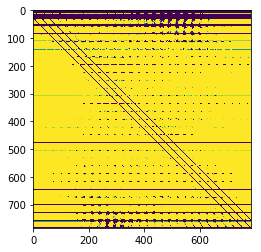

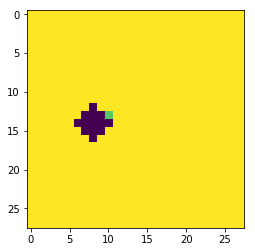

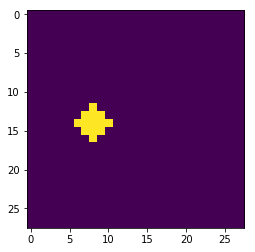

0.0
1.0


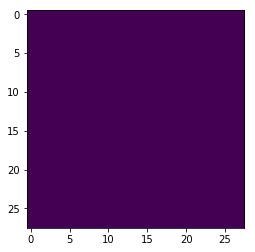

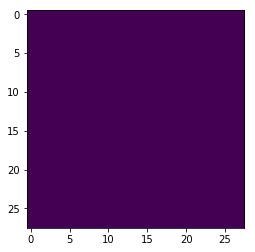

0.0
0.0


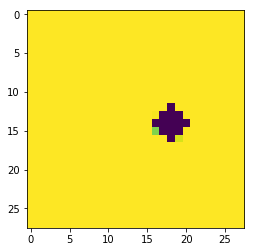

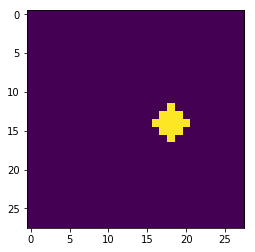

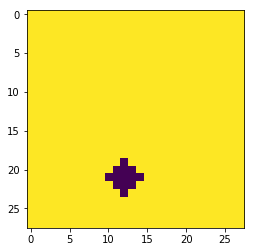

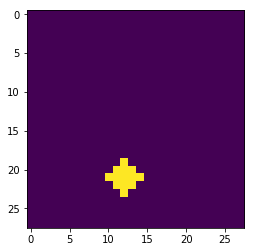

In [9]:

plt.imshow(D11[0])
plt.show()
plt.imshow(np.reshape(D11[0][400,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][400,:]==0,[28,28]))
plt.show()
print(D11[0][400,:].min())
print(D11[0][400,:].max())


plt.imshow(np.reshape(D11[0][1,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][1,:]==0,[28,28]))
plt.show()
print(D11[0][1,:].min())
print(D11[0][1,:].max())


plt.imshow(np.reshape(D11[0][410,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][410,:]==0,[28,28]))
plt.show()

plt.imshow(np.reshape(D11[0][600,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][600,:]==0,[28,28]))
plt.show()

#print(D11[0][400,:])
#plt.imshow(D12[0])
#plt.show()
#plt.imshow(np.reshape(D12[0][:,200],[28,28]))
#plt.show()

In [10]:
pred=decoder_model.predict(x_train)

In [11]:
print(pred.shape)
print(x_train.shape)


(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [12]:
error=np.sum(np.sum(abs(pred-dil_x_train),axis=1),axis=1)
v=np.argsort(error,axis=0)

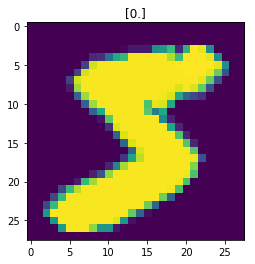

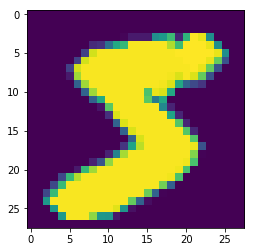

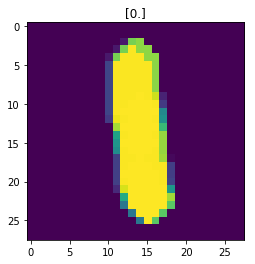

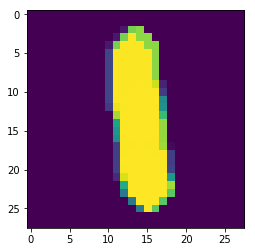

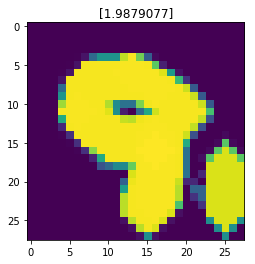

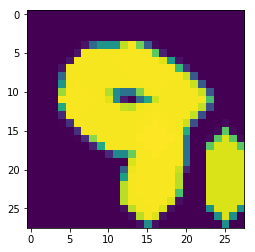

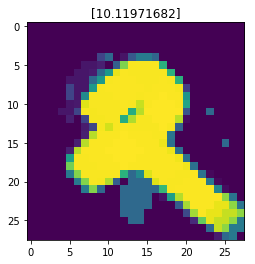

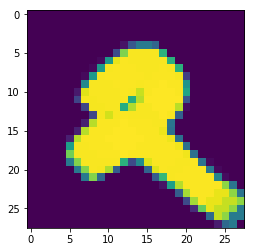

In [13]:
plt.imshow(pred[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_train[v[0][0],:,:,0])
plt.show()

plt.imshow(pred[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_train[v[11][0],:,:,0])
plt.show()

plt.imshow(pred[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_train[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_train[v[-1][0],:,:,0])
plt.show()

In [14]:
pred_test = decoder_model.predict(x_test)

In [15]:
error=np.sum(np.sum(abs(pred_test-dil_x_test),axis=1),axis=1)
v=np.argsort(error,axis=0)

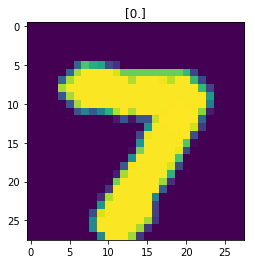

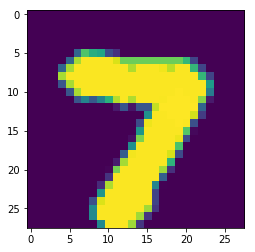

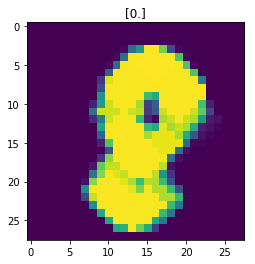

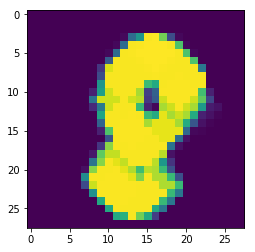

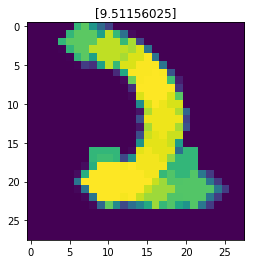

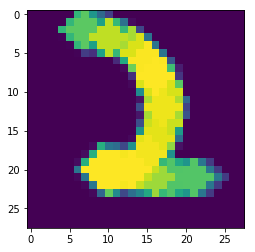

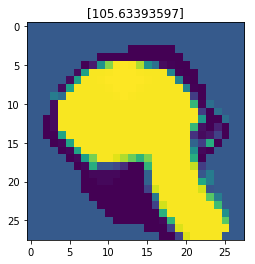

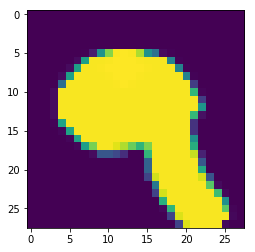

In [16]:
plt.imshow(pred_test[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_test[v[0][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_test[v[11][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_test[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_test[v[-1][0],:,:,0])
plt.show()

### Does regular Dense layer take as much time as the MaxPlusDenseLayer ?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../SourceCode')
from custom_constraints import Between_0_and_1

Using TensorFlow backend.


In [2]:
#NOTE: USE Dropout after MaxPlusDense

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [3]:
img_rows, img_cols = 28, 28
x_train=(x_train.astype('float32'))/255
x_test=(x_test.astype('float32'))/255
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

(60000, 28, 28) train samples
(10000, 28, 28) test samples


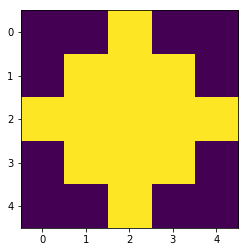

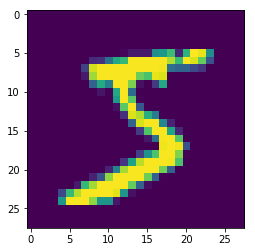

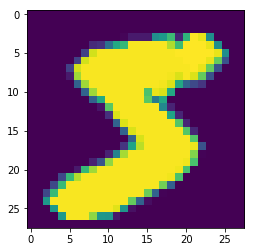

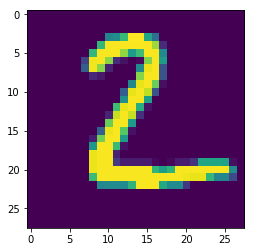

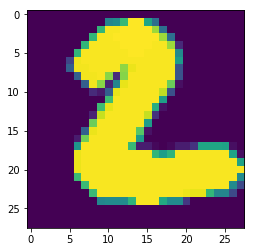

In [4]:
import skimage.morphology as skm
dil_x_train=np.zeros(x_train.shape)
SE=skm.disk(2)
for i in range(x_train.shape[0]):
    dil_x_train[i,:,:,0]=skm.dilation(x_train[i,:,:,0],SE)
dil_x_test = np.zeros(x_test.shape)
for i in range(x_test.shape[0]):
    dil_x_test[i,:,:,0]=skm.dilation(x_test[i,:,:,0],SE)
    
plt.imshow(SE,clim=[0,1])
plt.show()
plt.imshow(x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(x_test[1,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_test[1,:,:,0],clim=[0,1])
plt.show()

In [5]:
from keras.models import Model
from keras.layers import Input
from  keras.layers import Reshape
from keras.layers import Concatenate
from keras.layers import Maximum
from keras.constraints import non_neg
import keras

input_shape_decoder = (img_rows, img_cols,1)
input1 = Input(shape=input_shape)
x1=Flatten()(input1)
x2 = Dense(img_rows*img_cols,use_bias=False, kernel_constraint=Between_0_and_1(),name='MaxPlus7', kernel_initializer='zeros')(x1)
xx=Reshape((28,28,1))(x2)
decoder_model=Model(input1,xx)
decoder_model.summary()

print(x_train.shape)
print(dil_x_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
MaxPlus7 (Dense)             (None, 784)               614656    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 614,656
Trainable params: 614,656
Non-trainable params: 0
_________________________________________________________________
(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [6]:
decoder_model.compile(loss=keras.losses.mse,#binary_crossentropy
              optimizer=keras.optimizers.Adam(lr=.1),metrics=['mae'])

In [7]:
epochs = 1
batch_size = 32

decoder_model.fit(x_train, dil_x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/1
60000/60000 [==============================] - 36s 604us/step - loss: 0.0765 - mean_absolute_error: 0.0986


In [8]:
for layer in decoder_model.layers:
    print(layer.name)
    if layer.name=='MaxPlus7':
        D11 = layer.get_weights()
        print(len(D11))
        print(D11[0].shape)
        print(D11[0].min(),D11[0].max())


    if layer.name=='MaxPlus8':
        D12 = layer.get_weights()
        print(len(D12))
        print(D12[0].shape)
        print(D12[0].min(),D12[0].max())
        

input_1
flatten_1
MaxPlus7
1
(784, 784)
0.0 1.0
reshape_1


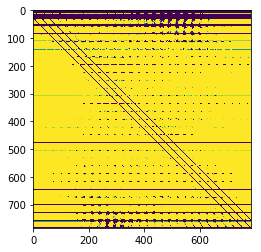

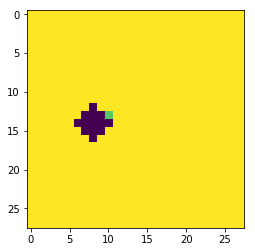

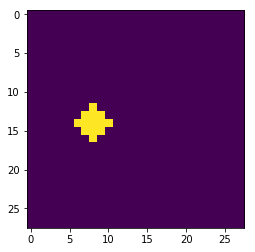

0.0
1.0


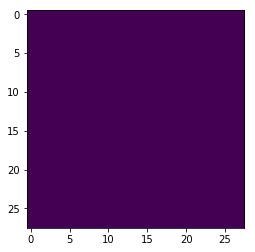

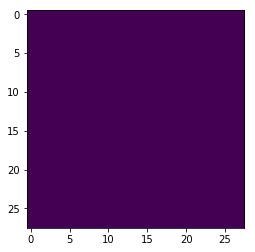

0.0
0.0


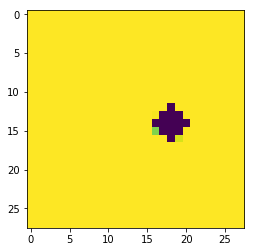

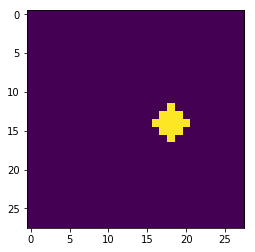

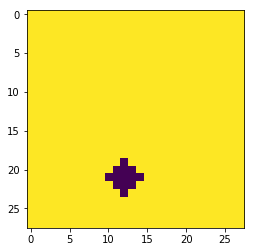

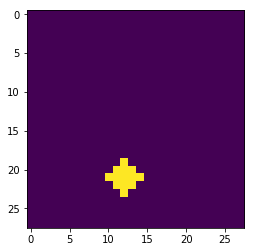

In [9]:

plt.imshow(D11[0])
plt.show()
plt.imshow(np.reshape(D11[0][400,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][400,:]==0,[28,28]))
plt.show()
print(D11[0][400,:].min())
print(D11[0][400,:].max())


plt.imshow(np.reshape(D11[0][1,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][1,:]==0,[28,28]))
plt.show()
print(D11[0][1,:].min())
print(D11[0][1,:].max())


plt.imshow(np.reshape(D11[0][410,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][410,:]==0,[28,28]))
plt.show()

plt.imshow(np.reshape(D11[0][600,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][600,:]==0,[28,28]))
plt.show()

#print(D11[0][400,:])
#plt.imshow(D12[0])
#plt.show()
#plt.imshow(np.reshape(D12[0][:,200],[28,28]))
#plt.show()

In [10]:
pred=decoder_model.predict(x_train)

In [11]:
print(pred.shape)
print(x_train.shape)


(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [12]:
error=np.sum(np.sum(abs(pred-dil_x_train),axis=1),axis=1)
v=np.argsort(error,axis=0)

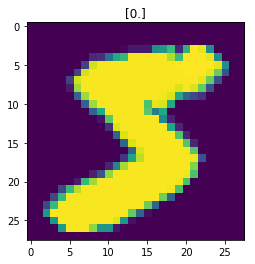

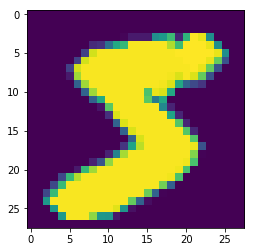

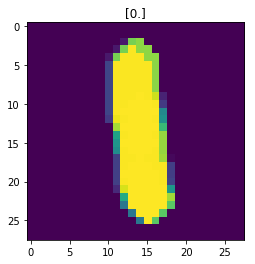

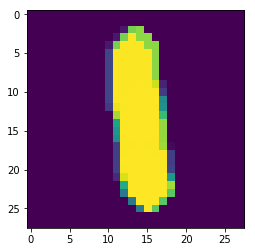

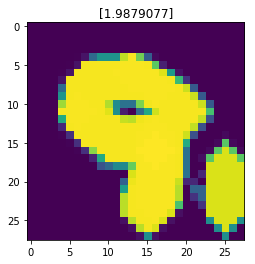

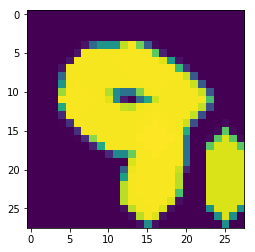

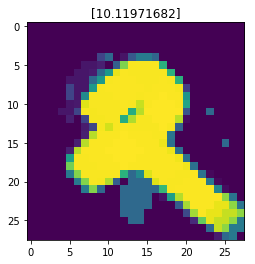

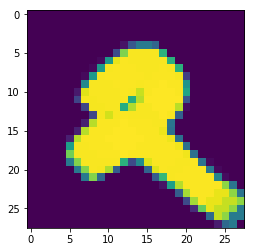

In [13]:
plt.imshow(pred[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_train[v[0][0],:,:,0])
plt.show()

plt.imshow(pred[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_train[v[11][0],:,:,0])
plt.show()

plt.imshow(pred[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_train[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_train[v[-1][0],:,:,0])
plt.show()

In [14]:
pred_test = decoder_model.predict(x_test)

In [15]:
error=np.sum(np.sum(abs(pred_test-dil_x_test),axis=1),axis=1)
v=np.argsort(error,axis=0)

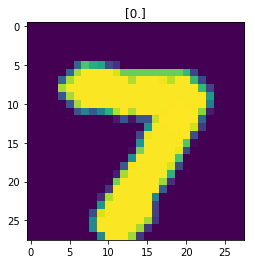

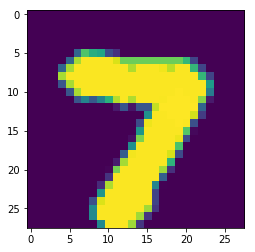

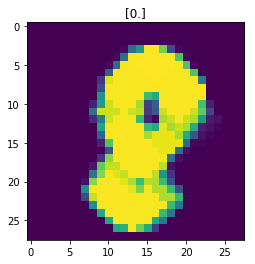

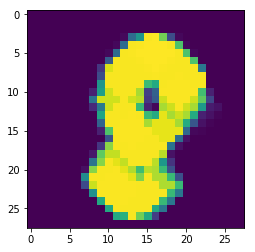

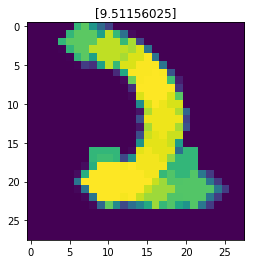

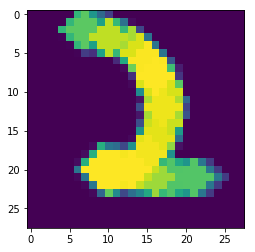

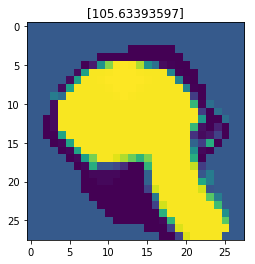

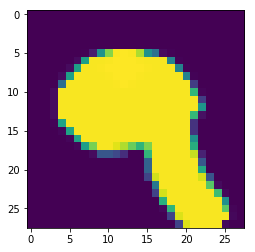

In [16]:
plt.imshow(pred_test[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_test[v[0][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_test[v[11][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_test[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_test[v[-1][0],:,:,0])
plt.show()

### Using all training points - No Constraints on the weights

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../SourceCode')
from MaxPlusDecoder import max_plus_dense_layer
from custom_constraints import Between_0_and_1

In [6]:
#NOTE: USE Dropout after MaxPlusDense

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

batch_size = 128

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [7]:
img_rows, img_cols = 28, 28
x_train=(x_train.astype('float32'))/255
x_test=(x_test.astype('float32'))/255
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

(60000, 28, 28) train samples
(10000, 28, 28) test samples


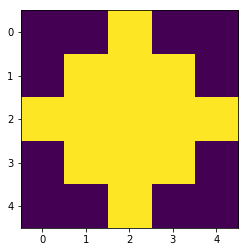

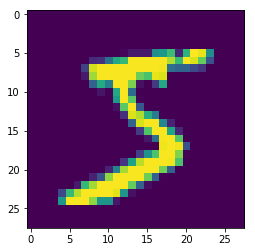

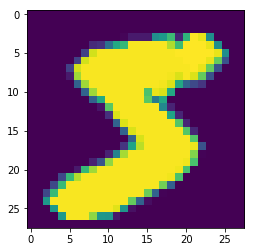

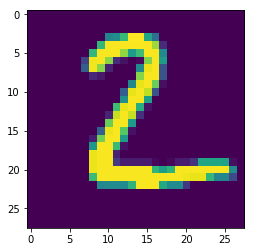

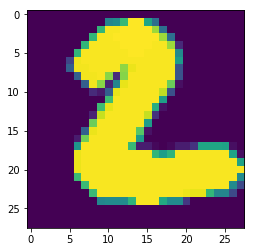

In [8]:
import skimage.morphology as skm
dil_x_train=np.zeros(x_train.shape)
SE=skm.disk(2)
for i in range(x_train.shape[0]):
    dil_x_train[i,:,:,0]=skm.dilation(x_train[i,:,:,0],SE)
dil_x_test = np.zeros(x_test.shape)
for i in range(x_test.shape[0]):
    dil_x_test[i,:,:,0]=skm.dilation(x_test[i,:,:,0],SE)
    
plt.imshow(SE,clim=[0,1])
plt.show()
plt.imshow(x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_train[0,:,:,0],clim=[0,1])
plt.show()
plt.imshow(x_test[1,:,:,0],clim=[0,1])
plt.show()
plt.imshow(dil_x_test[1,:,:,0],clim=[0,1])
plt.show()

In [9]:
from keras.models import Model
from keras.layers import Input
from  keras.layers import Reshape
from keras.layers import Concatenate
from keras.layers import Maximum
from keras.constraints import non_neg
import keras

input_shape_decoder = (img_rows, img_cols,1)
input1 = Input(shape=input_shape)
x1=Flatten()(input1)
x2 = max_plus_dense_layer.MaxPlusDense(img_rows*img_cols,use_bias=False, name='MaxPlus7', kernel_initializer='zeros')(x1)
xx=Reshape((28,28,1))(x2)
decoder_model=Model(input1,xx)
decoder_model.summary()

print(x_train.shape)
print(dil_x_train.shape)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
MaxPlus7 (MaxPlusDense)      (None, 784)               614656    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 614,656
Trainable params: 614,656
Non-trainable params: 0
_________________________________________________________________
(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [10]:
decoder_model.compile(loss=keras.losses.mse,#binary_crossentropy
              optimizer=keras.optimizers.Adam(lr=.1),metrics=['mae'])

In [11]:
epochs = 100
batch_size = 32

decoder_model.fit(x_train, dil_x_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)


Epoch 1/100
60000/60000 [==============================] - 1602s 27ms/step - loss: 0.0095 - mean_absolute_error: 0.0146
Epoch 2/100
  160/60000 [..............................] - ETA: 29:07 - loss: 1.7236e-06 - mean_absolute_error: 5.0958e-06

KeyboardInterrupt: 

In [10]:
import time
import numpy as np

In [9]:
a = np.random.uniform(size=784)
b = np.random.uniform()
c = np.random.uniform() 
t1 = time.time()
b*c
t2 = time.time()
time_multiplication = t2-t1
print('Time for multiplication:', time_multiplication)

t1 = time.time()
np.argmax(a)
t2 = time.time()
time_argmax = t2-t1
print('Time for argmax:', time_argmax)

rel_diff = 100*(time_argmax-time_multiplication)/time_multiplication
print('Relative difference: ', rel_diff)



Time for multiplication: 4.57763671875e-05
Time for argmax: 6.556510925292969e-05
Relative difference:  43.229166666666664


In [20]:
nb_test = 100
rel_diff = np.zeros(100)
W = np.random.uniform(size=(784,784))
X = np.random.uniform(size=(32,784)) 

for i in range(nb_test):
    t1 = time.time()
    output=np.dot(X,W)
    t2 = time.time()
    time_multiplication = t2-t1

    t1 = time.time()
    output=np.concatenate([X.reshape((-1, 784, 1))]*784, axis=-1)
    output -=W
    output = np.max(output, axis=1)
    t2 = time.time()
    time_argmax = t2-t1

    tmp = 100*(time_argmax-time_multiplication)/time_multiplication
    rel_diff[i] = tmp
    print('Test ',i,' - Relative difference: ', tmp)


Test  0  - Relative difference:  23556.943495657266
Test  1  - Relative difference:  22704.20847839443
Test  2  - Relative difference:  31653.240005772837
Test  3  - Relative difference:  32710.224026462187
Test  4  - Relative difference:  29999.714557564224
Test  5  - Relative difference:  26091.649546827794
Test  6  - Relative difference:  31111.793260993716
Test  7  - Relative difference:  33128.16426601287
Test  8  - Relative difference:  31984.860780747167
Test  9  - Relative difference:  32940.515700791424
Test  10  - Relative difference:  23849.455381233136
Test  11  - Relative difference:  29671.804181795418
Test  12  - Relative difference:  34530.82846142878
Test  13  - Relative difference:  28302.40182996569
Test  14  - Relative difference:  31761.918437679495
Test  15  - Relative difference:  32167.698732718894
Test  16  - Relative difference:  34848.18548387097
Test  17  - Relative difference:  31860.96429575485
Test  18  - Relative difference:  31248.599061299956
Test  19 

In [21]:
np.mean(rel_diff)

30582.684457343417

In [8]:
for layer in decoder_model.layers:
    print(layer.name)
    if layer.name=='MaxPlus7':
        D11 = layer.get_weights()
        print(len(D11))
        print(D11[0].shape)
        print(D11[0].min(),D11[0].max())


    if layer.name=='MaxPlus8':
        D12 = layer.get_weights()
        print(len(D12))
        print(D12[0].shape)
        print(D12[0].min(),D12[0].max())
        

input_1
flatten_1
MaxPlus7
1
(784, 784)
0.0 1.0
reshape_1


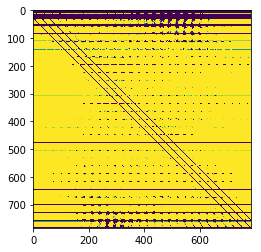

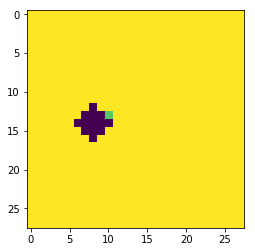

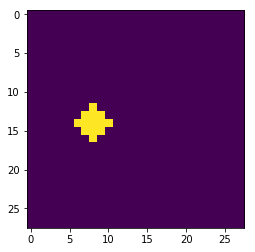

0.0
1.0


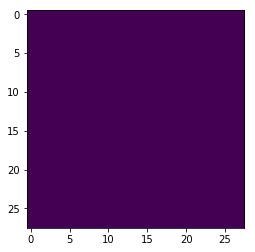

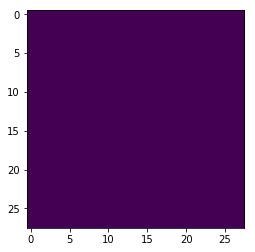

0.0
0.0


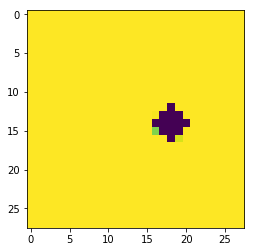

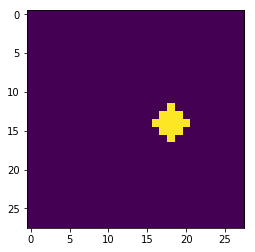

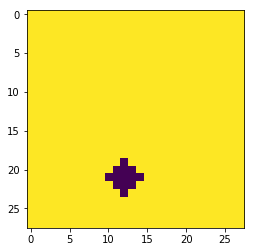

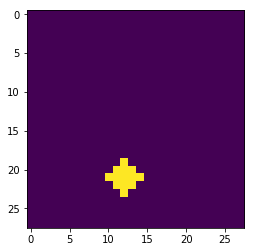

In [9]:

plt.imshow(D11[0])
plt.show()
plt.imshow(np.reshape(D11[0][400,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][400,:]==0,[28,28]))
plt.show()
print(D11[0][400,:].min())
print(D11[0][400,:].max())


plt.imshow(np.reshape(D11[0][1,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][1,:]==0,[28,28]))
plt.show()
print(D11[0][1,:].min())
print(D11[0][1,:].max())


plt.imshow(np.reshape(D11[0][410,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][410,:]==0,[28,28]))
plt.show()

plt.imshow(np.reshape(D11[0][600,:],[28,28]))
plt.show()
plt.imshow(np.reshape(D11[0][600,:]==0,[28,28]))
plt.show()

#print(D11[0][400,:])
#plt.imshow(D12[0])
#plt.show()
#plt.imshow(np.reshape(D12[0][:,200],[28,28]))
#plt.show()

In [10]:
pred=decoder_model.predict(x_train)

In [11]:
print(pred.shape)
print(x_train.shape)


(60000, 28, 28, 1)
(60000, 28, 28, 1)


In [12]:
error=np.sum(np.sum(abs(pred-dil_x_train),axis=1),axis=1)
v=np.argsort(error,axis=0)

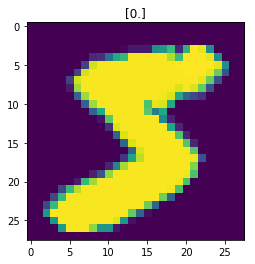

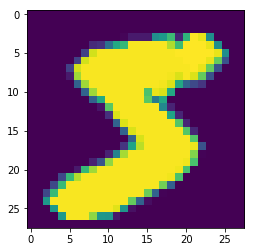

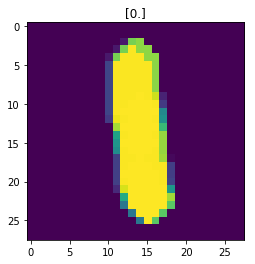

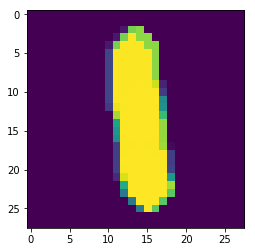

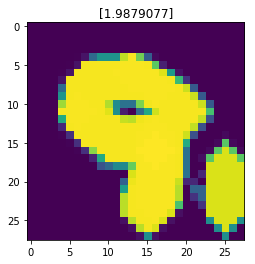

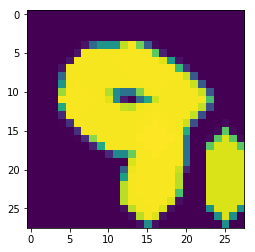

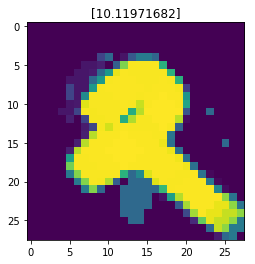

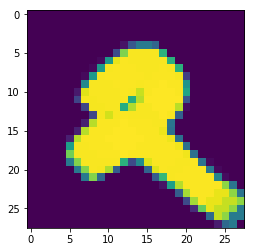

In [13]:
plt.imshow(pred[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_train[v[0][0],:,:,0])
plt.show()

plt.imshow(pred[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_train[v[11][0],:,:,0])
plt.show()

plt.imshow(pred[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_train[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_train[v[-1][0],:,:,0])
plt.show()

In [14]:
pred_test = decoder_model.predict(x_test)

In [15]:
error=np.sum(np.sum(abs(pred_test-dil_x_test),axis=1),axis=1)
v=np.argsort(error,axis=0)

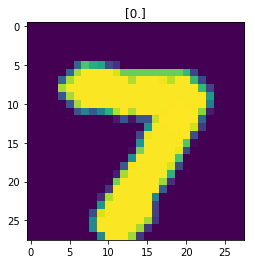

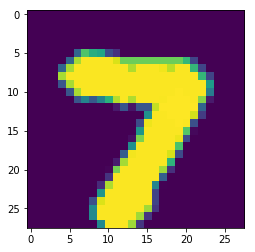

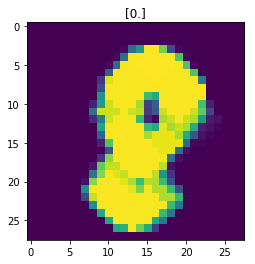

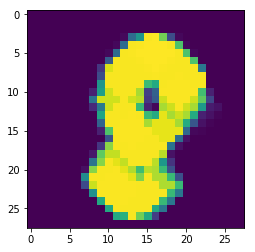

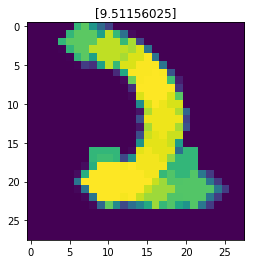

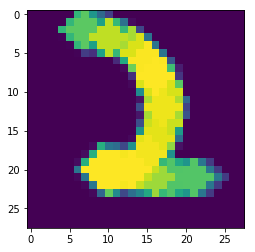

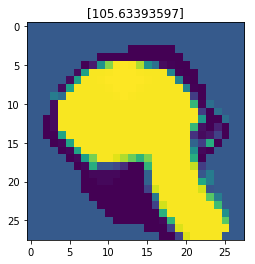

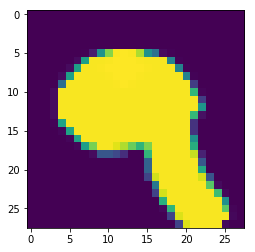

In [16]:
plt.imshow(pred_test[v[0][0],:,:,0])
plt.title(error[v[0][0]])
plt.show()
plt.imshow(dil_x_test[v[0][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[11][0],:,:,0])
plt.title(error[v[11][0]])
plt.show()
plt.imshow(dil_x_test[v[11][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-10][0],:,:,0])
plt.title(error[v[-10][0]])
plt.show()
plt.imshow(dil_x_test[v[-10][0],:,:,0])
plt.show()

plt.imshow(pred_test[v[-1][0],:,:,0])
plt.title(error[v[-1][0]])
plt.show()
plt.imshow(dil_x_test[v[-1][0],:,:,0])
plt.show()